In [1]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [2]:
import gymnasium as gym
from text_flappy_bird_gym import *
# from flappy_bird_gymnasium import *

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4, seed=0)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

env.reset()

((13, -3), {'score': 0, 'player': [6, 7], 'distance': 13.341664064126334})

In [4]:
class SARSAAgent():
    def __init__(self, hyper):
        self.N_ACTIONS = hyper['N_ACTIONS']
        self.epsilon = hyper['epsilon']
        self.eps_decay = hyper['eps_decay']
        self.lr = hyper['lr']
        self.discount = hyper['discount']
        self.seed = hyper['seed']
        self.rand_generator = np.random.RandomState(hyper['seed'])
        self.Q = defaultdict(lambda: 0)
        
        self.pre_state = 0
        self.pre_action = 0
    
    def argmax(self, q_values):
        top = float('-inf')
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = [i]
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)

    def agent_start(self, state):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
        
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_step(self, reward, state, episode, num_episodes):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
            
        predict = self.Q[self.pre_state, self.pre_action]
        target = reward + self.discount * self.Q[state, action]
        
        self.Q[self.pre_state, self.pre_action] += self.lr*(target - predict)
            
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_end(self, reward):
        self.Q[self.pre_state, self.pre_action] += self.lr * (reward - self.Q[self.pre_state, self.pre_action])
        

    def train(self, env, num_episodes):
        # self.num_episodes = num_episodes
        scores = []
        for episode in tqdm(range(num_episodes)):
            state, _ = env.reset()
            if episode == 0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state, episode, num_episodes)
                    # if done:
                    #     self.agent_end(reward)
                    #     break
                    if (info['score'] >1e2) or done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                scores.append(info['score'])
            self.epsilon = max(self.epsilon * self.eps_decay, 0.005)
            if episode % 1000 == 0: print(self.epsilon)
        return np.array(scores)

    def test(self, env, n_episodes):
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            while not done:
                action = np.argmax([self.Q[state,0], self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                state = next_state
                if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                    break
            scores.append(info['score'])
        return np.array(scores)

    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.Q[state,0], self.Q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.1) # FPS
        return info['score']

In [5]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()

((13, 1), {'score': 0, 'player': [6, 7], 'distance': 13.038404810405298})

 11%|█         | 1077/10000 [00:00<00:01, 4466.90it/s]

0.49975
0.3030757977143385


 21%|██▏       | 2143/10000 [00:00<00:04, 1949.19it/s]

0.18380177920996957


 32%|███▏      | 3239/10000 [00:01<00:06, 1115.85it/s]

0.11146747544847624


 41%|████      | 4106/10000 [00:03<00:09, 618.23it/s] 

0.0675999880755381


 51%|█████     | 5079/10000 [00:04<00:09, 530.42it/s]

0.04099633879234308


 61%|██████    | 6072/10000 [00:07<00:09, 408.10it/s]

0.02486242737940289


 71%|███████   | 7112/10000 [00:10<00:06, 426.66it/s]

0.015077938991750478


 81%|████████  | 8078/10000 [00:13<00:06, 304.47it/s]

0.009144088820035772


 90%|█████████ | 9036/10000 [00:17<00:03, 273.67it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:21<00:00, 470.98it/s]


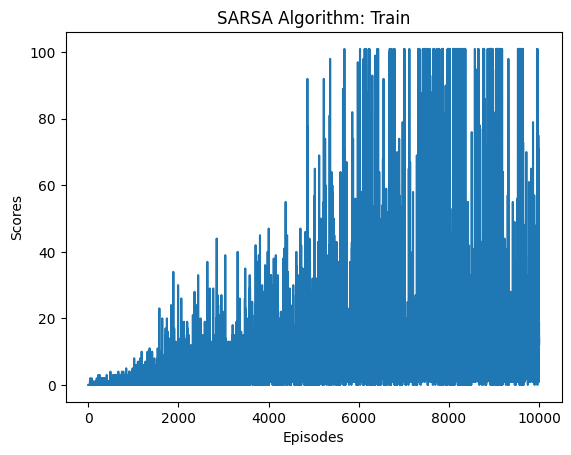

In [7]:
hyper = {}
hyper['N_ACTIONS'] = 2
hyper['epsilon'] = 0.5
hyper['eps_decay'] = 0.9995
hyper['lr'] = 0.4
hyper['discount'] = 0.9
hyper['seed'] = None
hyper['rand_generator'] = np.random.RandomState(hyper['seed'])
# hyper['Q'] = defaultdict(lambda: 0)

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
game = SARSAAgent(hyper)
n_episodes = 10000
train_score = game.train(env, n_episodes)
plt.plot(train_score)
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title(f"SARSA Algorithm: Train")
plt.show()

In [8]:
Q = defaultdict(lambda: 0)

In [9]:
env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4)
state, _ = env.reset()
tuple(map(tuple, state))

((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2))

 11%|█▏        | 1143/10000 [00:00<00:02, 3386.15it/s]

0.49975
0.3030757977143385


 23%|██▎       | 2276/10000 [00:01<00:04, 1736.36it/s]

0.18380177920996957


 32%|███▏      | 3221/10000 [00:02<00:06, 1024.88it/s]

0.11146747544847624


 41%|████      | 4105/10000 [00:03<00:08, 711.42it/s] 

0.0675999880755381


 51%|█████     | 5097/10000 [00:04<00:08, 589.19it/s]

0.04099633879234308


 60%|██████    | 6018/10000 [00:07<00:12, 322.07it/s]

0.02486242737940289


 71%|███████   | 7051/10000 [00:10<00:12, 238.71it/s]

0.015077938991750478


 81%|████████  | 8053/10000 [00:14<00:07, 252.50it/s]

0.009144088820035772


 90%|█████████ | 9012/10000 [00:17<00:04, 218.17it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:23<00:00, 427.06it/s]


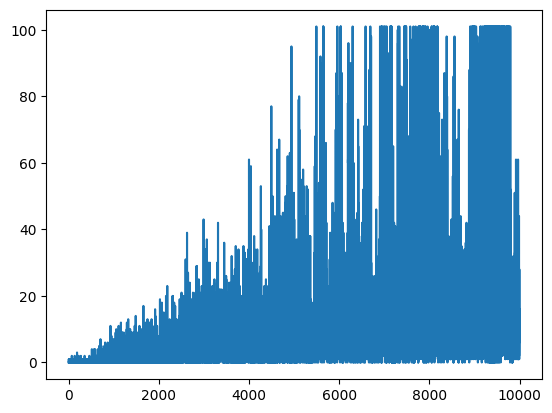

In [10]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
game = SARSAAgent(hyper)

n_episodes = 10000
train_scores = game.train(env, n_episodes)
plt.plot(train_scores)

In [11]:
env = gym.make('TextFlappyBird-v0', height=10, width=20, pipe_gap=4)
game.run(env)

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[                |   ]
[                |   ]
[                |   ]
[                |   ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                |   ]
[                |   ]
^^^^^^^

101

100%|██████████| 100/100 [00:00<00:00, 568.41it/s]

Average scores over 100 test episodes: 18.05
Median scores over 100 test episodes: 13.5


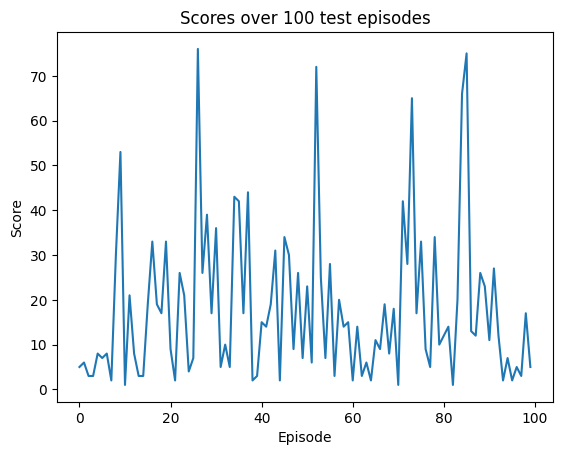

In [12]:
# test the trained agent for 100 episodes
n_episodes=100
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
test_scores = game.test(env,n_episodes=n_episodes)
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()